In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models 
from torchvision import transforms
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, Subset, ConcatDataset, DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd

from algo import EmpBH, adaptiveEmpBH

In [2]:
def get_fdp(ytrue, rejection_set):
    """
    """

    if rejection_set.size:
        fdp = np.sum(ytrue[rejection_set] == 0) / len(rejection_set)
        tdp = np.sum(ytrue[rejection_set] == 1) / np.sum(ytrue==1)
    else: 
        fdp=0
        tdp=0
    return fdp, tdp

### Classification Model

In [3]:
class BinaryConvNet(nn.Module):
    def __init__(self, in_channels):
        super(BinaryConvNet, self).__init__()
        self.dim_target=1

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [4]:
class NNClassifier(object):
    """
    wrapper around NN model with fit() and predict_proba() functions
    """
    def __init__(self, model, batch_size=128, n_epochs=10):

        self.model = model #eg resnet152 = models.resnet152(pretrained=True)
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.loss_fn = nn.BCEWithLogitsLoss() 
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        self.n_iter_no_change=10
        self.tol = 1e-4

    def fit(self, train_dataset, val_dataset=None):
        train_loader = DataLoader(train_dataset,batch_size=self.batch_size,shuffle=True)
        
        if val_dataset is not None: 
            val_loader = DataLoader(val_dataset,batch_size=self.batch_size,shuffle=False)

        #for early stopping
        best_val_acc = 0
        it_no_change = 0

        for _ in range(self.n_epochs):
            for x_batch, y_batch in train_loader:
                self.model.train()
                y_pred = self.model(x_batch)
                y_batch = y_batch.unsqueeze(-1)
                loss = self.loss_fn(y_pred,y_batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            #must use early stopping to avoid overfitting: if validation accuracy has not improved by tol in n_iter_no_change steps, then stop
            if val_dataset is not None: 
                with torch.no_grad(): #after each epoch
                    val_acc =0
                    for x_val, y_val in val_loader:
                        self.model.eval()
                        yhat = self.model(x_val)
                        yhat = yhat.softmax(dim=-1) #probabilities 
                        y_val = y_val.squeeze().long()
                        acc = torch.sum(torch.argmax(yhat,dim=1) == y_val).item() #to check
                        val_acc += acc
                    val_acc /= len(val_loader.dataset)
                
                    if val_acc > best_val_acc + self.tol:
                        best_val_acc = val_acc
                        it_no_change =0 #reset 
                    else:
                        it_no_change+=1 #increment counter of number of iterations without val acc improvement 
                        if it_no_change > self.n_iter_no_change: #break if too much 
                            break 
        #print("val accuracy", val_acc)


    def predict_proba(self, test_dataset):
        test_loader = DataLoader(test_dataset,batch_size=len(test_dataset),shuffle=False)

        with torch.no_grad():
            for x,y in test_loader: 
                self.model.eval()
                yhat_unnormed = self.model(x)
                #yhat = yhat_unnormed.softmax(dim=-1) #probabilities 
                yhat_logit= nn.functional.sigmoid(yhat_unnormed)
                return yhat_logit.numpy()

### Data pre-processing

Import data

In [5]:
train_data = datasets.MNIST(
    root = 'data',
    train=True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████| 9912422/9912422 [00:01<00:00, 9835067.32it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████| 28881/28881 [00:00<00:00, 171300.06it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████| 1648877/1648877 [00:00<00:00, 2830282.45it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████████████████████████████| 4542/4542 [00:00<00:00, 2949454.83it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [7]:
train_data[0][0].shape

torch.Size([1, 28, 28])

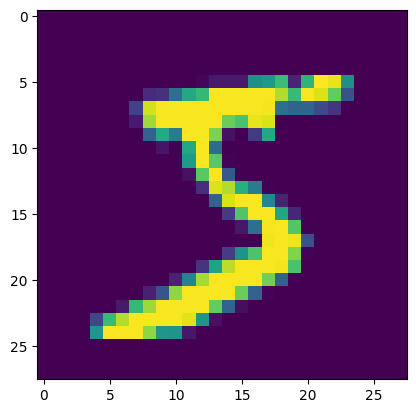

In [8]:
plt.imshow(train_data[0][0].reshape(28,28))

Nulls = 4, Outliers = 9

In [9]:
class custom_subset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
        labels(sequence) : targets as required for the indices. will be the same length as indices
    """
    def __init__(self, dataset, indices, labels=None):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.targets = dataset.targets[indices] if labels is None else labels
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        target = self.targets[idx]
        return (image, target)

    def __len__(self):
        return len(self.targets)

In [10]:
inlr_labels=[4]
outlr_labels=[9]

inlr = (torch.tensor(train_data.targets)[..., None] == torch.tensor(inlr_labels)).any(-1).nonzero(as_tuple=True)[0]
outlr = (torch.tensor(train_data.targets)[..., None] == torch.tensor(outlr_labels)).any(-1).nonzero(as_tuple=True)[0]

print(len(inlr), len(outlr))

5842 5949


/var/folders/bn/8y89tyhd1ns2ty8kpkn64q840000gn/T/ipykernel_23316/3491230173.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inlr = (torch.tensor(train_data.targets)[..., None] == torch.tensor(inlr_labels)).any(-1).nonzero(as_tuple=True)[0]
/var/folders/bn/8y89tyhd1ns2ty8kpkn64q840000gn/T/ipykernel_23316/3491230173.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outlr = (torch.tensor(train_data.targets)[..., None] == torch.tensor(outlr_labels)).any(-1).nonzero(as_tuple=True)[0]


### Apply AdaDetect (averaging on 100 runs)

In [11]:
level=0.1
test_size = 1000
null_prop = 0.90
n_inlr = int(test_size * null_prop)
n_outlr = test_size - n_inlr
calib_size= 1000
train_size= 3000

n_runs=10

fdp, tdp = [0.]*n_runs, [0.]*n_runs

for i in range(n_runs):
    # construct test dataset
    test_idx = np.concatenate([np.random.choice(inlr, replace=False, size = n_inlr),
                           np.random.choice(outlr, replace=False, size = n_outlr)
                          ])
    test_dataset = custom_subset(train_data, test_idx, torch.ones(test_size)) #set labels as 1 for learning 

     # construct training dataset
    train_idx = np.setdiff1d(inlr, test_idx) 
    
    np.random.shuffle(train_idx)
    n=train_size+calib_size#len(train_idx)
    ar1 = train_idx[:calib_size] #calibration sample
    ar2 = train_idx[calib_size:n] #training sample 

    calib_dataset = custom_subset(train_data, ar1, torch.ones(calib_size))
    train_dataset = custom_subset(train_data, ar2, torch.zeros(n-calib_size))
    training_dataset = torch.utils.data.ConcatDataset([train_dataset, calib_dataset, test_dataset]) 

    #train CNN on training dataset
    n_channels = 1 #grey scale images 
    model = BinaryConvNet(in_channels=n_channels)

    clf = NNClassifier(model, batch_size=32, n_epochs=10)
    clf.fit(train_dataset=training_dataset, val_dataset=None,)

    #compute statistics/scores and apply BH
    test_statistics = clf.predict_proba(test_dataset)
    null_statistics = clf.predict_proba(calib_dataset) 
    rej_set = EmpBH(null_statistics, test_statistics, level=level)
    
    #test_labels = train_data.targets[test_idx].numpy() #true test labels 
    test_labels = np.concatenate([np.zeros(n_inlr), np.ones(n_outlr)])
    fdp_, tdp_ = get_fdp(test_labels, rej_set)
    
    fdp[i]=fdp_; tdp[i]=tdp_
    
print("fdp", np.mean(fdp), np.std(fdp))
print("tdp", np.mean(tdp), np.std(tdp))

fdp 0.09195430800517276 0.03469769472102192
tdp 0.923 0.0857962703152066


### Illustration

For illustration, let's sample from the accepted and from the rejections, according to the proportion of each. Then, we can circle rejections. 

In [ ]:
print(len(rej_set), len(test_dataset))

In [32]:
#idx_rej = test_idx[rej_set]
idx_rej = rej_set

idx_acc = np.setdiff1d(np.arange(len(test_dataset)), idx_rej)
sample_rej = np.random.choice(idx_rej, replace=False, size=10)
sample_acc = np.random.choice(idx_acc, replace=False, size=38)

samples = np.concatenate([sample_rej, sample_acc]) 
np.random.shuffle(samples)

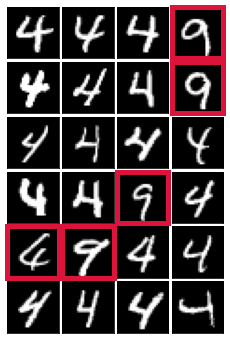

In [33]:

images = [test_dataset[i][0][0] for i in samples]
fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(6, 4),  # creates 2x2 grid of axes
                 axes_pad=0.05,  # pad between axes in inch.
                 )

for ax, idx, im in zip(grid, samples, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')
    ax.tick_params(bottom=False, top=False, left=False, right=False,
                  labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    
    if idx in sample_rej: 
        ax.spines['bottom'].set_color('crimson')
        ax.spines['top'].set_color('crimson') 
        ax.spines['right'].set_color('crimson')
        ax.spines['left'].set_color('crimson')
        ax.spines["bottom"].set_linewidth(5)
        ax.spines["top"].set_linewidth(5)
        ax.spines["right"].set_linewidth(5)
        ax.spines["left"].set_linewidth(5)

plt.show()